In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
np.random.seed(1)
# read the npz file in the folder
folder = '/shared-local/aoq609/MLLM_ICL/ICL/outs/I00150000_K256_N8_L32_D63_a_0.00_B1_pB_1.00_pC_0.80_e0.100_lr0.010_nr1/iter0'
labels_classes = np.load(folder + '/labels_classes.npz')
targets_num_iter = np.load(folder + '/targets_num_iter.npy')

In [2]:
# Read the date before emergence of ICL 
params_before_ICL = np.load(folder + '/params00028000.npz')
params_during_ICL = np.load(folder + '/params00032000.npz')
params_after_ICL = np.load(folder + '/params00050000.npz')


## Sample an IC input

In [3]:
from transformer_v2 import *
from datasets_v2 import *
K=256
L=32
N=8
D=63
alpha=0
B=1
eps=0.1
Nmax=32
P = 1.0/(np.arange(1,K+1)**alpha)
P /= np.sum(P)
mus_label, mus_class, labels_class = get_mus_label_class(K,L,D)
test_inputs_ic, test_labels_ic, label_sequences =  generate_input_seqs(mus_label,mus_class,labels_class,1,N, Nmax,eps = eps, P = P, B = 1, p_B = 1, p_C = 1, no_repeats = True, seq_labels=True)
print("Sequence Labels")
print(label_sequences[0])

Sequence Labels
[30  4 28 11  6 18 12 16  6]


## Prepare Model

In [4]:
def attention_head_score(QKV, seq,mask = None):
    querys,keys,values = [jnp.einsum('ijk,lk->ijl',seq,x) for x in QKV] #(batchsize x seq_length x input_dim) 
    
    if mask is None:
        mask = jnp.zeros((seq.shape[1],seq.shape[1]))
        
    probs = jax.nn.softmax(mask[None,:,:] + jnp.einsum('...ij,...kj->...ik',keys,querys),axis=-2)

    out = jnp.einsum('...ij,...ik->...jk',probs,values) #(batchsize x seq_length x input_dim)

    return probs, out

def get_attention(params,inputs):
    x = inputs
    
    mask = jnp.ones((x.shape[1],x.shape[1]))*(-jnp.inf)
    mask = jnp.tril(mask, k = -1)
    attn_1, out_1 =  attention_head_score(params[0],x,mask=mask)  
    attn_2, out_2 =  attention_head_score(params[1],x + out_1,mask=mask)
    
    return attn_1, attn_2


## Change of the Attentin Map for the two layers before, during and after ICl Emerge

/tmp/ipykernel_3574830/2066476245.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make space for colorbar


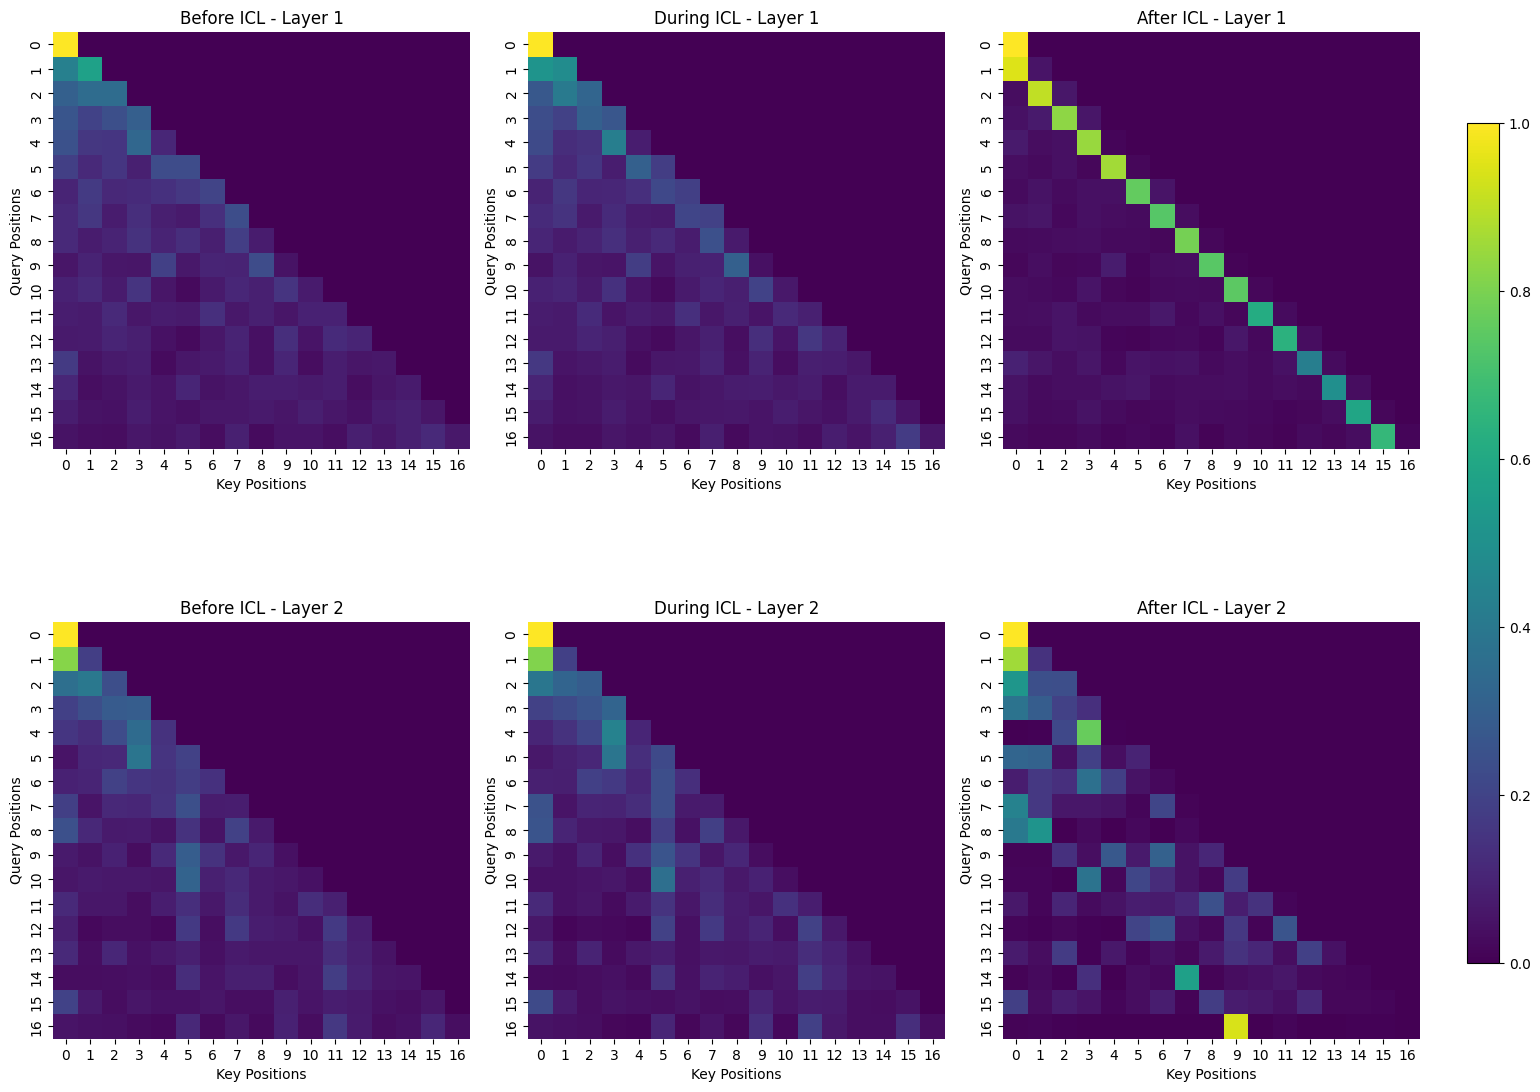

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot attention matrices
def plot_attention_matrices(attn_1, attn_2, axes, col_index, cbar_ax=None):
    """Plots attention matrices for two layers, aligning them in a column."""
    attn_matrix_1 = attn_1[0].T
    sns.heatmap(attn_matrix_1, cmap="viridis", annot=False, fmt=".2f", square=True, ax=axes[0, col_index], cbar=False)
    axes[0, col_index].set_title(["Before ICL", "During ICL", "After ICL"][col_index] + " - Layer 1")
    axes[0, col_index].set_xlabel("Key Positions")
    axes[0, col_index].set_ylabel("Query Positions")
    
    attn_matrix_2 = attn_2[0].T
    sns.heatmap(attn_matrix_2, cmap="viridis", annot=False, fmt=".2f", square=True, ax=axes[1, col_index], cbar=False)
    axes[1, col_index].set_title(["Before ICL", "During ICL", "After ICL"][col_index] + " - Layer 2")
    axes[1, col_index].set_xlabel("Key Positions")
    axes[1, col_index].set_ylabel("Query Positions")

    # Add a colorbar outside the grid, to the right
    if cbar_ax is not None:
        fig.colorbar(axes[0, col_index].collections[0], cax=cbar_ax)

# Create a figure with 2 rows and 3 columns (layers as rows, ICL states as columns)
fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# Create an additional axis for the colorbar on the right of the heatmaps
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Right side of the figure

# Before ICL
q1, k1, v1, q2, k2, v2 = params_before_ICL['arr_0'], params_before_ICL['arr_1'], params_before_ICL['arr_2'], params_before_ICL['arr_3'], params_before_ICL['arr_4'], params_before_ICL['arr_5']
params = np.array([[q1, k1, v1], [q2, k2, v2]])
attn_1, attn_2 = get_attention(params, test_inputs_ic)
plot_attention_matrices(attn_1, attn_2, axes, col_index=0, cbar_ax=cbar_ax)

# During ICL
q1, k1, v1, q2, k2, v2 = params_during_ICL['arr_0'], params_during_ICL['arr_1'], params_during_ICL['arr_2'], params_during_ICL['arr_3'], params_during_ICL['arr_4'], params_during_ICL['arr_5']
params = np.array([[q1, k1, v1], [q2, k2, v2]])
attn_1, attn_2 = get_attention(params, test_inputs_ic)
plot_attention_matrices(attn_1, attn_2, axes, col_index=1, cbar_ax=cbar_ax)

# After ICL
q1, k1, v1, q2, k2, v2 = params_after_ICL['arr_0'], params_after_ICL['arr_1'], params_after_ICL['arr_2'], params_after_ICL['arr_3'], params_after_ICL['arr_4'], params_after_ICL['arr_5']
params = np.array([[q1, k1, v1], [q2, k2, v2]])
attn_1, attn_2 = get_attention(params, test_inputs_ic)
plot_attention_matrices(attn_1, attn_2, axes, col_index=2, cbar_ax=cbar_ax)

# Adjust layout to ensure no overlap and colorbar is on the right
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make space for colorbar

plt.show()


### Target attention

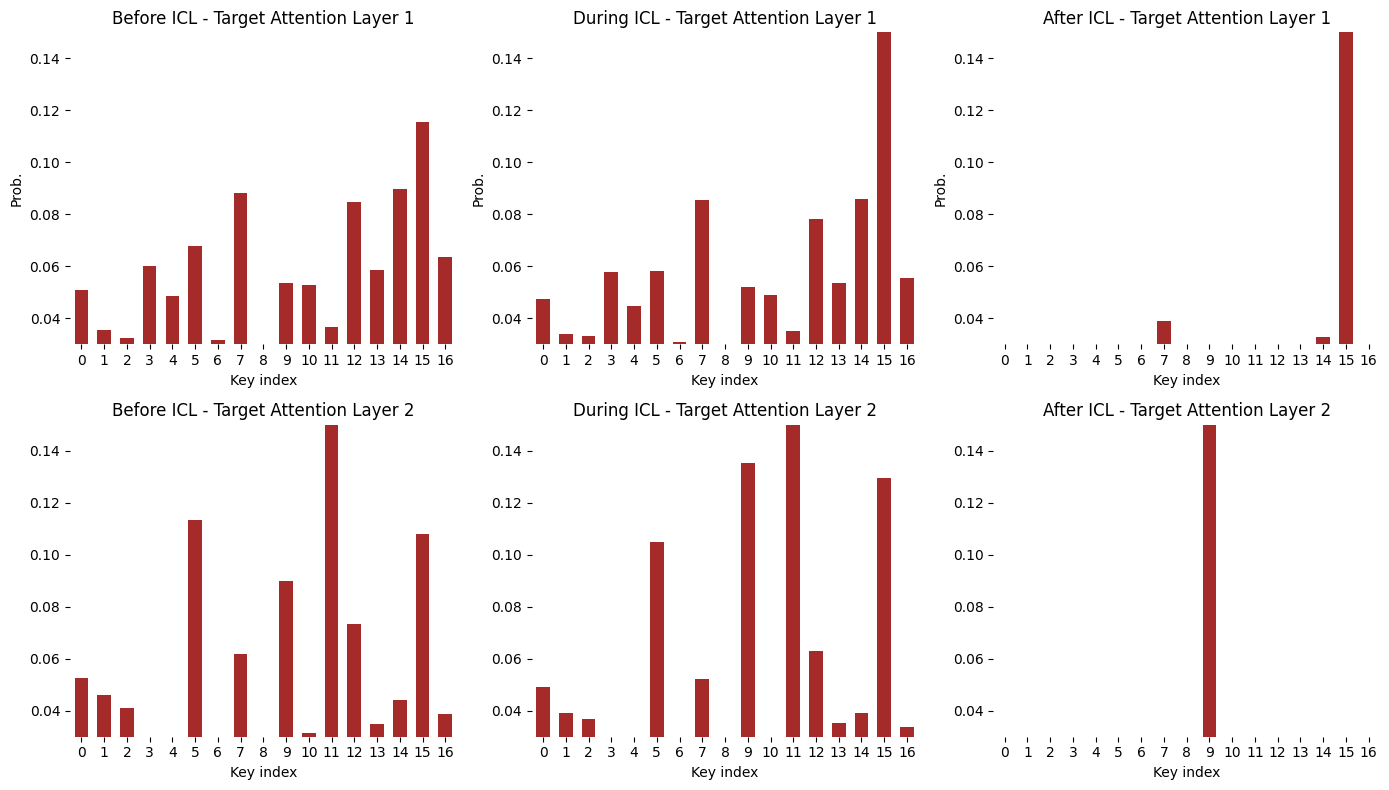

In [6]:
def plot_attention_distributions(attn_1, attn_2, axes, title_prefix):
    attn_1_T = attn_1[0].T
    attn_2_T = attn_2[0].T
    
    data1 = attn_1_T[-1]
    data2 = attn_2_T[-1]
    
    axes[0].bar(range(len(data1)), data1, color='brown', width=0.6)
    axes[0].set_xlabel("Key index")
    axes[0].set_ylabel("Prob.")
    axes[0].set_xticks(range(len(data1)))
    axes[0].set_xticklabels(range(len(data1)))
    axes[0].set_ylim(0.03, 0.15)
    axes[0].set_xlim(-0.5, len(data1) - 0.5)
    axes[0].set_title(f"{title_prefix} - Target Attention Layer 1")
    for spine in axes[0].spines.values():
        spine.set_visible(False)
    
    axes[1].bar(range(len(data2)), data2, color='brown', width=0.6)
    axes[1].set_xlabel("Key index")
    axes[1].set_xticks(range(len(data2)))
    axes[1].set_xticklabels(range(len(data2)))
    axes[1].set_ylim(0.03, 0.15)
    axes[1].set_xlim(-0.5, len(data2) - 0.5)
    axes[1].set_title(f"{title_prefix} - Target Attention Layer 2")
    for spine in axes[1].spines.values():
        spine.set_visible(False)

# Create a single figure with six subplots for attention matrices
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.T  # Transpose the axes to have two columns

# Before ICL
q1, k1, v1, q2, k2, v2 = params_before_ICL['arr_0'], params_before_ICL['arr_1'], params_before_ICL['arr_2'], params_before_ICL['arr_3'], params_before_ICL['arr_4'], params_before_ICL['arr_5']
params = np.array([[q1, k1, v1], [q2, k2, v2]])
attn_1, attn_2 = get_attention(params, test_inputs_ic)
plot_attention_distributions(attn_1, attn_2, axes[0], "Before ICL")

# During ICL
q1, k1, v1, q2, k2, v2 = params_during_ICL['arr_0'], params_during_ICL['arr_1'], params_during_ICL['arr_2'], params_during_ICL['arr_3'], params_during_ICL['arr_4'], params_during_ICL['arr_5']
params = np.array([[q1, k1, v1], [q2, k2, v2]])
attn_1, attn_2 = get_attention(params, test_inputs_ic)
plot_attention_distributions(attn_1, attn_2, axes[1], "During ICL")

# After ICL
q1, k1, v1, q2, k2, v2 = params_after_ICL['arr_0'], params_after_ICL['arr_1'], params_after_ICL['arr_2'], params_after_ICL['arr_3'], params_after_ICL['arr_4'], params_after_ICL['arr_5']
params = np.array([[q1, k1, v1], [q2, k2, v2]])
attn_1, attn_2 = get_attention(params, test_inputs_ic)
plot_attention_distributions(attn_1, attn_2, axes[2], "After ICL")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()
